In [27]:
import cv2 as cv
from matplotlib import pyplot as plt
import glob
import numpy as np
import os

In [66]:
def draw_matches(img1, kp1, img2, kp2, matches): 
    """
    Python implementation of draw matches to allow configuration of line width and colour
    """
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    r = 15
    thickness = 5
    red = (0, 0, 255)
    for m in matches:
        end1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv.line(new_img, end1, end2, red, thickness)
        cv.circle(new_img, end1, r, red, thickness)
        cv.circle(new_img, end2, r, red, thickness)
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
    plt.show()

In [71]:
def draw_matches_manual(img1, kp1, img2, kp2): 
    """
    Python implementation of draw matches to allow drawing manual keypoint correspondences
    """
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    r = 15
    thickness = 5
    red = (0, 0, 255)
    for i in range(len(kp1)):
        end1 = tuple(np.round(kp1[i]).astype(int))
        end2 = tuple(np.round(kp2[i]).astype(int) + np.array([img1.shape[1], 0]))
        cv.line(new_img, end1, end2, red, thickness)
        cv.circle(new_img, end1, r, red, thickness)
        cv.circle(new_img, end2, r, red, thickness)
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
    plt.show()

### Load Images

In [6]:
filenames = glob.glob("photos/*.jpg")
print(f"{len(filenames)} images found")
images = [cv.imread(f) for f in filenames]

27 images found


### Display Images

In [7]:
rows = len(images) // 5
cols = (len(images) // rows) + 1

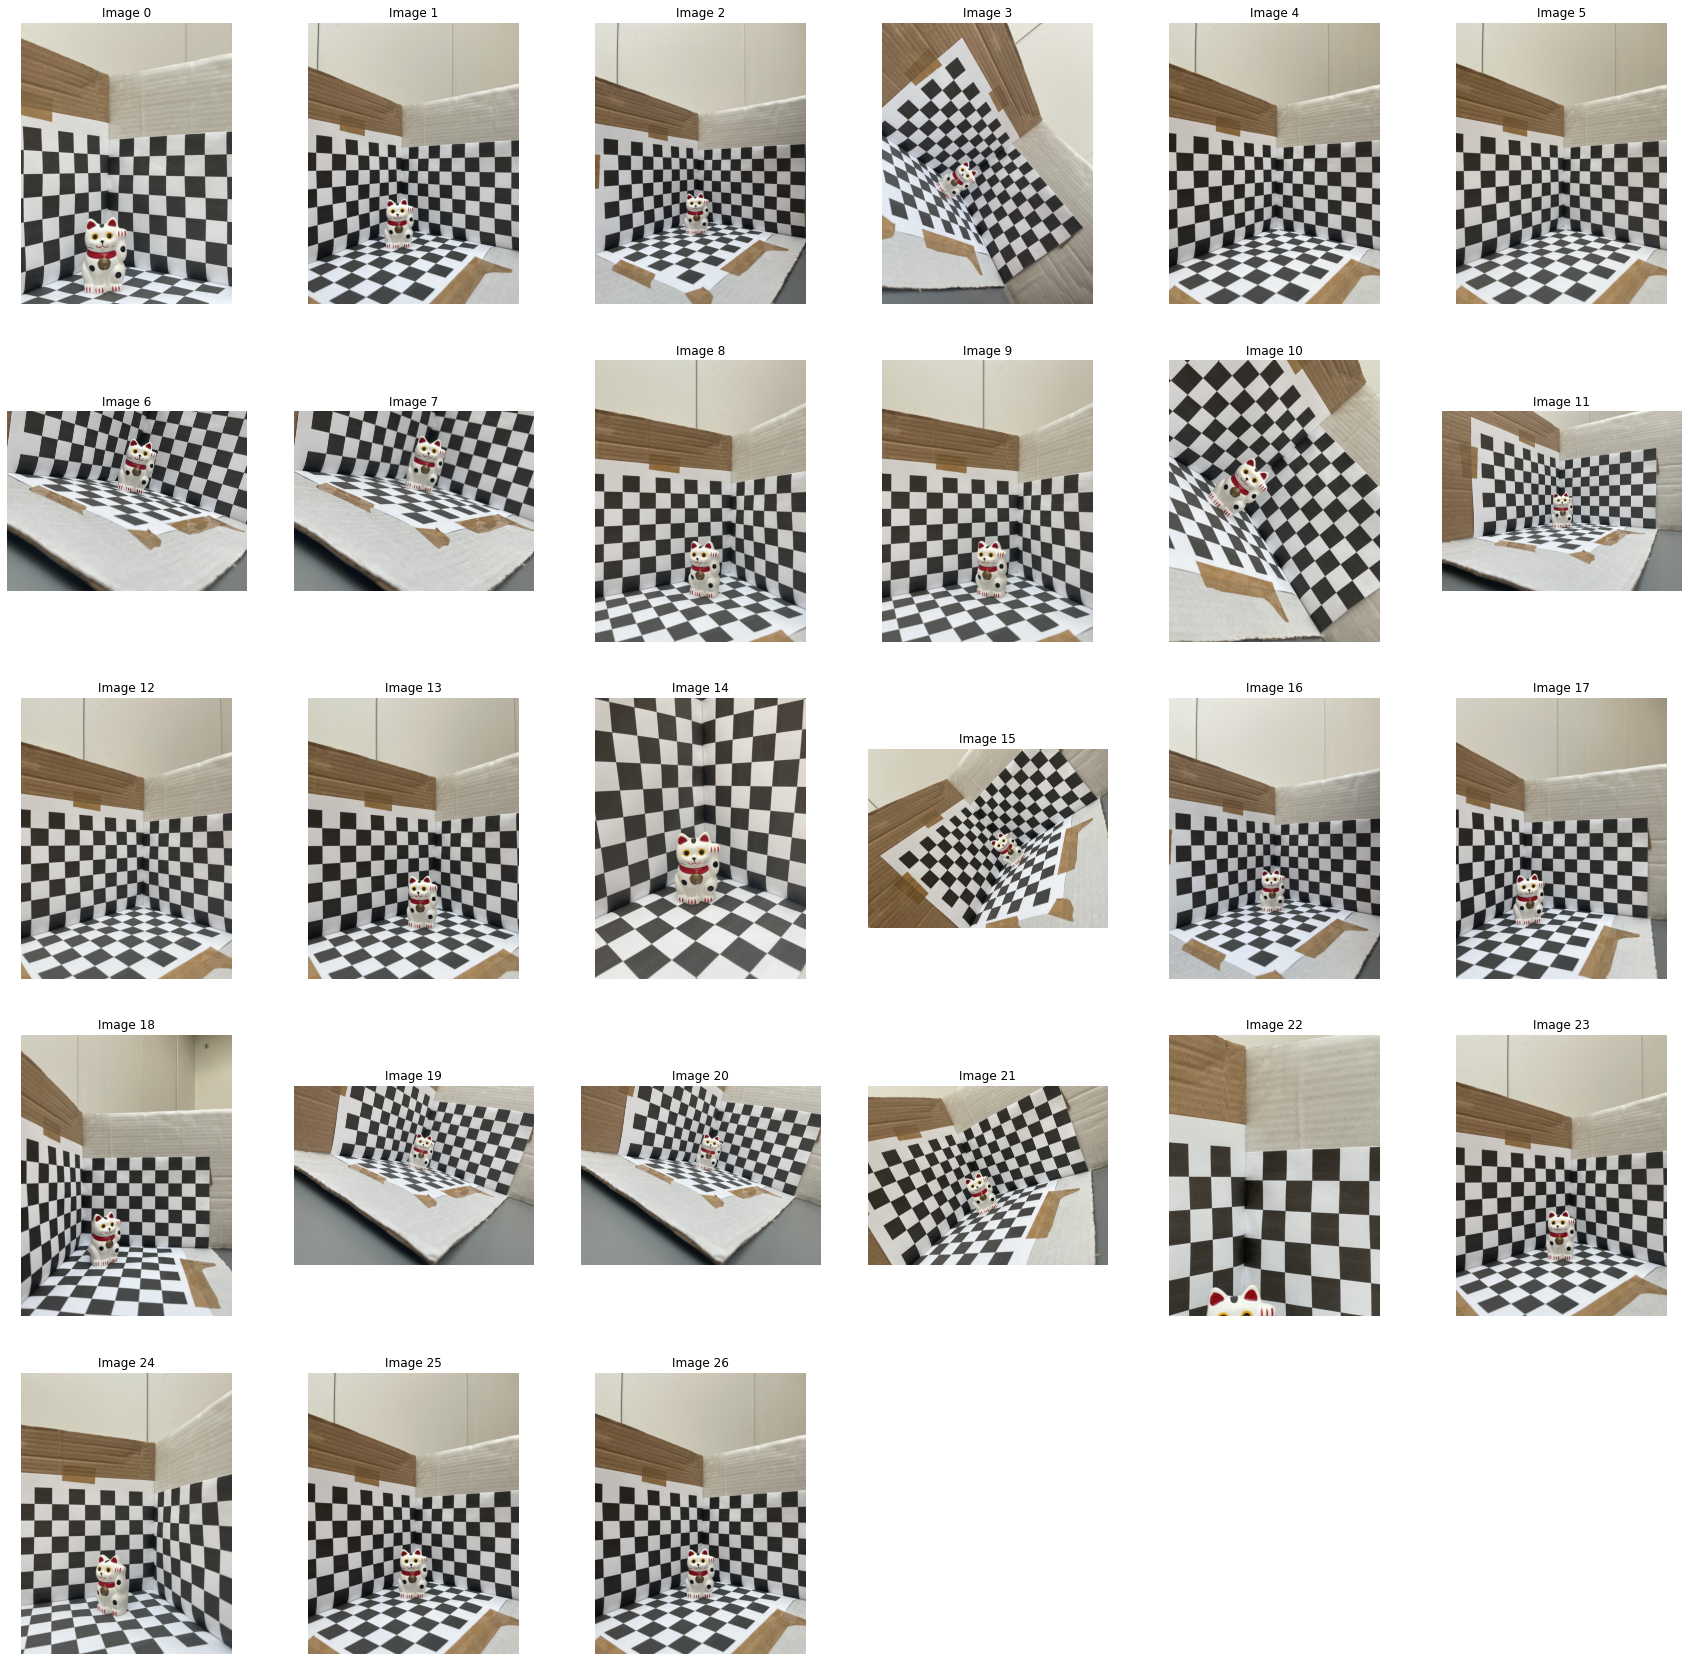

In [8]:
# This cell takes a while to run :( - consider commenting out if re-running notebook

fig = plt.figure(figsize=(30, 30))
for i in range(len(images)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images[i][...,::-1]) # BGR to RGB - OpenCV image to Matplotlib
    plt.axis("off")
    plt.title(f"Image {i}")

### Keypoint correspondences between images
Compare quality/quantity of correspondences found by two methods:
- Manual (clicking on corresponding points)
- Automatic (detecting keypoint and matching descriptors)

#### Manual keypoint correspondence

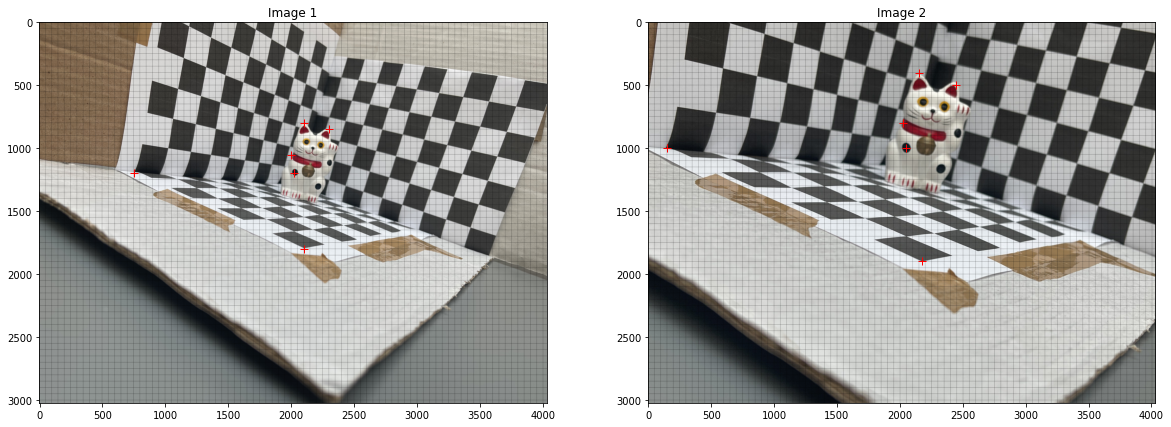

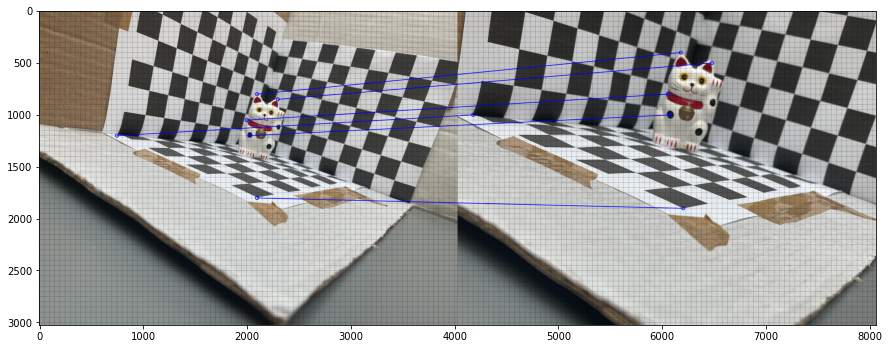

In [73]:
img1 = cv.imread(os.path.join("photos", "keypoint_correspond_1.jpg"))
img2 = cv.imread(os.path.join("photos", "keypoint_correspond_2.jpg"))
# Grid lines at these intervals (in pixels)
# dx and dy can be different
dx, dy = 50,50
# Custom (rgb) grid color
grid_color = [0,0,0]
# Modify the image to include the grid
img1[:,::dy,:] = grid_color
img1[::dx,:,:] = grid_color
img2[:,::dy,:] = grid_color
img2[::dx,:,:] = grid_color

kp1 = np.array([[2000, 1050], 
                [2100, 800], 
                [2300, 850],
               [2025, 1200],
               [750, 1200], 
               [2100, 1800]])


kp2 = np.array([[2025, 800], 
                [2150, 400], 
                [2450, 500],
               [2050, 1000],
               [150, 1000], 
               [2175, 1900]])

rows, cols = 1,2
fig = plt.figure(figsize=(20,20))
fig.add_subplot(rows, cols, 1)
plt.imshow(img1[...,::-1])
for coord in kp1:
    plt.plot(coord[0], coord[1], 'r+', markersize=8)
plt.title(f"Image 1")
fig.add_subplot(rows, cols, 2)
plt.imshow(img2[...,::-1])
for coord in kp2:
    plt.plot(coord[0], coord[1], 'r+', markersize=8)
plt.title(f"Image 2")

draw_matches_manual(img1[...,::-1], kp1, img2[...,::-1], kp2)

#### Automatic keypoint correspondence using SIFT

In [75]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

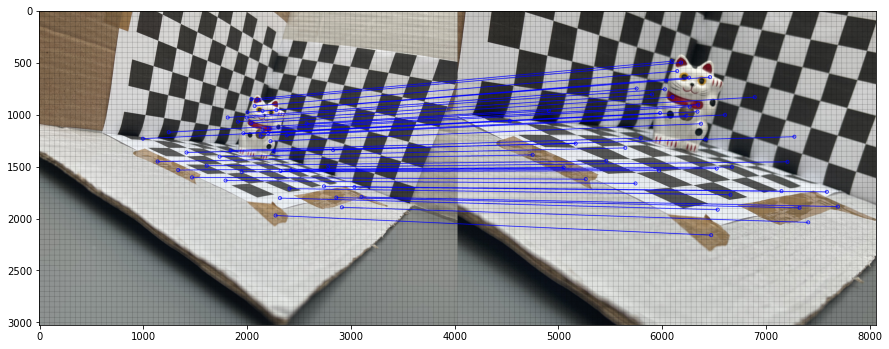

In [76]:
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append(m)
draw_matches(img1[...,::-1],kp1,img2[...,::-1],kp2, good)

In [79]:
rows, cols, channels = img1.shape

print("Image dims:", rows, cols, channels)

idxs = []
for match in good:
    img1_idx = dmatch.queryIdx
    img2_idx = dmatch.trainIdx
    pair = (kp1[img1_idx].pt, kp2[img2_idx].pt)
    idxs.append(pair)
    
print(f"{len(idxs)} keypoint pairs")

Image dims: 3024 4032 3
51 keypoint pairs


In [84]:
np.array(idxs).shape

(51, 2, 2)

### Camera calibration
- Find and report camera parameters.
- Can you estimate or illustrate distortions of your camera?

### Transformation estimation
- Estimate a homography matrix between a pair of images from HG.
    - Show the keypoints and their correspondences projected from the other image.
- Estimate fundamental matrix between a pair of images from FD.
    - Show the keypoints and their corresponding epipolar lines in the other image.
    - Show epipoles, vanishing points and horizon in your images.
- find out how many outliers the estimation method tolerates

### 3D geometry
- Show a stereo rectified pair of your images with epipolar lines.
- Calculate and display depth map of your object estimated from different views.